In [81]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import FunctionTransformer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
# Load the data
data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

In [14]:
# Check for missing values
print(data.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


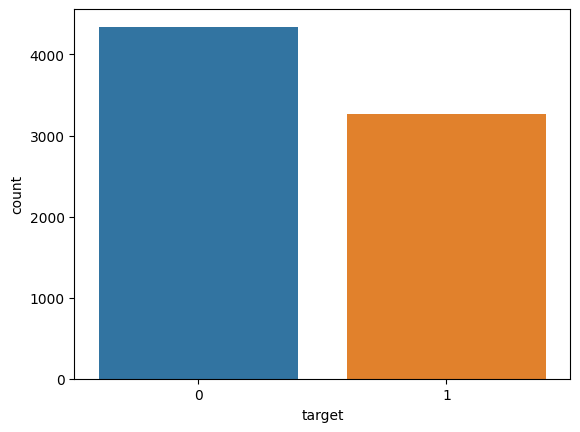

In [15]:
sns.countplot(x='target', data=data)
plt.show()

In [16]:
# Check for class imbalance
print(data['target'].value_counts())

target
0    4342
1    3271
Name: count, dtype: int64


In [17]:
# Check the number of unique keywords
print("Number of unique keywords:", data['keyword'].nunique())

Number of unique keywords: 221


In [18]:
# Check the number of unique locations
print("Number of unique locations:", data['location'].nunique())

Number of unique locations: 3341


In [19]:
# Analyze the text length
data['text_length'] = data['text'].apply(len)
print(data['text_length'].describe())

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text_length, dtype: float64


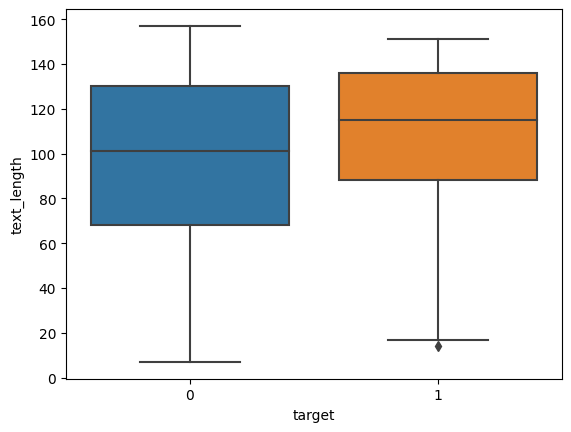

In [20]:
# Visualize the text length per each class
sns.boxplot(x='target', y='text_length', data=data)
plt.show()

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
# Most common words in the text
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.text)
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print('Most common words:', words_freq[:10])

Most common words: [('http', 4309), ('https', 411), ('like', 348), ('û_', 348), ('amp', 344), ('just', 323), ('new', 226), ('people', 200), ('news', 197), ('don', 190)]


In [23]:
# Shuffle the training dataframe
data_shuffled = data.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility

In [24]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

def preprocess_text(sen):
    # Remove urls
    sentence = re.sub(r'http\S+|www\S+|https\S+', '', sen, flags=re.MULTILINE)
    # Remove user @ references and '#' from sentence
    sentence = re.sub(r'\@\w+|\#','', sentence)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    # Convert to lower case
    sentence = sentence.lower()
    # Remove stop words and perform stemming
    sentence = sentence.split()
    ps = PorterStemmer()
    sentence = [
        ps.stem(word)
        for word in sentence
        if word not in set(stopwords.words('english'))
    ]
    sentence = ' '.join(sentence)
    return sentence

This code defines a function called `preprocess_text` that takes a raw text input (a tweet in this case) and performs a series of preprocessing steps to clean and normalize the text. The purpose of this preprocessing is to reduce noise, remove irrelevant information, and transform the text into a format that can be easily understood by a machine learning model. Let's go through each step in the function and explain the reasoning behind it.

1. Remove URLs: Since URLs do not provide any useful information for the task of identifying disaster tweets, they are removed using a regular expression pattern that matches common URL formats.

```python
sentence = re.sub(r'http\S+|www\S+|https\S+', '', sen, flags=re.MULTILINE)
```

2. Remove user @ references and hashtags (#): Usernames and hashtags are also removed as they may not contribute to the classification task.

```python
sentence = re.sub(r'\@\w+|\#','', sentence)
```

3. Remove punctuations and numbers: Punctuations and numbers are removed to simplify the text and focus on the words themselves.

```python
sentence = re.sub('[^a-zA-Z]', ' ', sentence)
```

4. Single character removal: Single characters are removed as they usually do not carry meaningful information for the classification task.

```python
sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
```

5. Removing multiple spaces: Multiple spaces are replaced with a single space to maintain a consistent format.

```python
sentence = re.sub(r'\s+', ' ', sentence)
```

6. Convert to lower case: Converting all characters to lower case helps in reducing the dimensionality of the data and ensures that words with different capitalizations are treated as the same word.

```python
sentence = sentence.lower()
```

7. Remove stop words and perform stemming: Stop words are common words that do not carry much information and can be removed to reduce noise. Stemming is the process of reducing words to their root form, which helps in grouping similar words together and reducing the overall vocabulary size.

```python
sentence = sentence.split()
ps = PorterStemmer()
sentence = [
    ps.stem(word)
    for word in sentence
    if word not in set(stopwords.words('english'))
]
sentence = ' '.join(sentence)
```

By applying these preprocessing steps, the input text is transformed into a cleaner and more structured format that can be easily fed into a machine learning model. This can help improve the model's performance and reduce the training time.

In [25]:
data_shuffled.head()

,id,keyword,location,text,target,text_length
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1,66
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0,119
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1,125
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0,114
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0,105


In [26]:
data_shuffled['text'] = data_shuffled['text'].apply(preprocess_text)

In [28]:
# Most common words in the text
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data_shuffled.text)
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print('Most common words:', words_freq[:10])

Most common words: [('like', 411), ('amp', 344), ('bomb', 239), ('new', 227), ('news', 207), ('peopl', 200), ('time', 181), ('kill', 181), ('burn', 180), ('year', 178)]


In [29]:
from sklearn.feature_extraction.text import CountVectorizer

In [30]:
X = data_shuffled['text']
y = data_shuffled['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

TfidfVectorizer() and MultinomialNB() are two popular techniques used in text classification tasks, such as the Kaggle Natural Language Processing with Disaster Tweets competition. Let's understand each of them and why using them as a baseline model is a good idea.

1. TfidfVectorizer():

TfidfVectorizer is a feature extraction technique that converts raw text data into a matrix of term frequency-inverse document frequency (TF-IDF) features. It is a combination of two metrics: term frequency (TF) and inverse document frequency (IDF).

- Term Frequency (TF): It measures the frequency of a term (word) in a document. A higher value indicates that the term appears more frequently in the document.
- Inverse Document Frequency (IDF): It measures the importance of a term across all documents in the corpus. A higher value indicates that the term is rare and carries more information.

The main idea behind using TF-IDF is to give more importance to words that are unique to a document and less importance to words that are common across all documents. This helps in capturing the essence of each document and improves the performance of text classification tasks.

2. MultinomialNB():

MultinomialNB is a Naive Bayes classifier specifically designed for text classification tasks. It is based on the Multinomial Naive Bayes algorithm, which is a probabilistic model that calculates the probability of a document belonging to a particular class based on the frequency of words in the document. It assumes that the features (words) are conditionally independent given the class label, which simplifies the computation.

Using TfidfVectorizer() and MultinomialNB() as a baseline model for text classification tasks is a good idea because:

- They are easy to implement and computationally efficient.
- They provide a strong baseline performance, which can be further improved using more advanced techniques.
- They work well with small to medium-sized datasets and can handle sparse data effectively.
- They can be easily combined with other techniques, such as feature engineering, model tuning, and ensemble methods, to achieve better performance.

# Model 01

In [31]:
model_01 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

# Train the model
model_01.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In the given code snippet, a pipeline is created with TfidfVectorizer() for feature extraction and MultinomialNB() for classification. As a baseline model, it provides a good starting point for further improvements and experimentation.

In [32]:
# Predict the labels
y_pred = model_01.predict(X_test)

In [33]:
def calculate_scores(y_test, y_pred):
    # Calculate the scores
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1) 

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
    }

In [34]:
baseline_model_results_01 = calculate_scores(y_test, y_pred)

Accuracy: 0.8031496062992126
Precision: 0.8138788984085914
Recall: 0.8031496062992126
F1 Score: 0.7990389367128067


In [35]:
# Tokenize and pad the text data
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

In [36]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

# Model 02

In [37]:
from tensorflow.keras.layers import GlobalAveragePooling1D

In [38]:
# Create the dense model
model_02 = Sequential([
    Embedding(max_words, 32, input_length=max_len),
    GlobalAveragePooling1D(),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
], name="DenseModel")

We have a Sequential model here as our 2nd model, which is a type of model that is composed of a linear stack of layers. The Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

The model consists of four layers:

1. **Embedding Layer**: This layer is used as the first layer for text processing tasks in neural networks. It turns positive integers (indexes) into dense vectors of fixed size. The `max_words` parameter is the size of the vocabulary in the text data, `32` is the output dimension of the vectors, and `max_len` is the length of input sequences. The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.

2. **GlobalAveragePooling1D Layer**: This layer is used to reduce the dimensionality of the input. It averages the sequence dimension (dimension of index 1) of the input and hence reduces its size. This is useful when you want to reduce the computational cost by reducing the dimensionality and complexity of the input data.

3. **Dense Layer**: This is a regular densely-connected Neural Network (NN) layer with 32 neurons. It implements the operation: `output = activation(dot(input, kernel) + bias)` where `activation` is the element-wise activation function passed as the `activation` argument (in this case, "relu" or Rectified Linear Unit), `kernel` is a weights matrix created by the layer, and `bias` is a bias vector created by the layer.

4. **Dense Layer**: This is another densely-connected NN layer but with only 1 neuron. The activation function is "sigmoid". The sigmoid function outputs a value between 0 and 1 which makes it a very good option for binary classification problems. In this case, it will output the probability of a tweet being about a real disaster.

The benefit of this model is its simplicity and efficiency. The Embedding layer reduces the dimensionality of the input data, making it easier to process. The GlobalAveragePooling1D layer further reduces the dimensionality, making the model computationally efficient. The Dense layers then perform the classification task. The model is also flexible and can be easily modified or extended for more complex tasks.

In [39]:
model_02.summary()

Model: "DenseModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           320000    
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 321,089
Trainable params: 321,089
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Compile and train the model
model_02.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
dense_model_02 = model_02.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), verbose=2)

Epoch 1/5
191/191 - 21s - loss: 0.6835 - accuracy: 0.5691 - val_loss: 0.6821 - val_accuracy: 0.5634 - 21s/epoch - 111ms/step
Epoch 2/5
191/191 - 3s - loss: 0.6744 - accuracy: 0.5721 - val_loss: 0.6676 - val_accuracy: 0.5634 - 3s/epoch - 18ms/step
Epoch 3/5
191/191 - 2s - loss: 0.6281 - accuracy: 0.6351 - val_loss: 0.5957 - val_accuracy: 0.7118 - 2s/epoch - 12ms/step
Epoch 4/5
191/191 - 1s - loss: 0.4914 - accuracy: 0.8087 - val_loss: 0.4853 - val_accuracy: 0.7925 - 1s/epoch - 5ms/step
Epoch 5/5
191/191 - 1s - loss: 0.3748 - accuracy: 0.8606 - val_loss: 0.4575 - val_accuracy: 0.7997 - 1s/epoch - 7ms/step


In [41]:
# Evaluate the model
y_pred = (model_02.predict(X_val) > 0.5).astype("int32")

dense_model_results_02 = calculate_scores(y_val, y_pred)

48/48 [==============================] - 0s 2ms/step
Accuracy: 0.7997373604727511
Precision: 0.8010655855126176
Recall: 0.7997373604727511
F1 Score: 0.7974256671985269


In [42]:
from keras.layers import LSTM, Dropout

In [43]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

**Caution: Beware of Data Leakage**

As you prepare your machine learning models, it's crucial to be aware of a common pitfall known as data leakage. Data leakage can lead to overly optimistic performance estimates and can mislead you into thinking your model is performing better than it actually is.

**Types of Data Leakage:**

1. **Target Leakage:** This occurs when your predictors include data that will not be available at the time you make predictions. Always consider the timing or chronological order that data becomes available, not merely whether a feature helps make good predictions.

2. **Train-Test Contamination:** This type of leakage occurs when you aren't careful to distinguish training data from validation data. Validation is meant to be a measure of how the model does on data it hasn't seen before. If the validation data affects the preprocessing behavior, it can corrupt this process. This is sometimes called train-test contamination.

**Preventing Data Leakage:**

To prevent data leakage, ensure that any preprocessing or feature engineering does not include data from the validation or test sets. Also, be sure to carefully consider the data used in your features to avoid target leakage. 

Remember, a model's true performance is measured by its ability to make predictions on new, unseen data. Any leakage that gives the model access to information it wouldn't have in a real-world application can lead to misleading results.

In [44]:
# Split the data into training and testing sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(data_shuffled['text'], data_shuffled['target'], test_size=0.2, random_state=42)

# Define the parameters
max_features = 10000
embedding_dim = 128
sequence_length = 15

# Define the text vectorization layer
vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Fit the text vectorization layer on the training data
vectorize_layer.adapt(X_train_lstm.to_list())

This code is part of a process to prepare data for a Long Short-Term Memory (LSTM) model, which is a type of Recurrent Neural Network (RNN) that is particularly effective for Natural Language Processing (NLP) tasks. The LSTM model can learn patterns over time, making it suitable for text data that has a sequential nature.

The first line of code is splitting the shuffled data into training and testing sets. This is a common practice in machine learning to evaluate the performance of the model. The `train_test_split` function from the sklearn library is used here. The `test_size` parameter is set to 0.2, meaning that 20% of the data will be used for testing, and the remaining 80% will be used for training. The `random_state` parameter is set to ensure that the splits generate the same set of data every time the code is run.

Next, three parameters are defined: `max_features`, `embedding_dim`, and `sequence_length`. 

- `max_features` is the maximum number of words to keep, based on word frequency. Only the most common `max_features` words will be kept. This is done to limit the size of the vocabulary to the most relevant words and to avoid overfitting.

- `embedding_dim` is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. The larger the embedding dimension, the more complex the semantic relationships that can be captured, but also the more parameters the model will have.

- `sequence_length` is the length of sequences to be fed into the LSTM. If a text has fewer words than `sequence_length`, it will be padded with zeros; if it has more, it will be truncated.

The `TextVectorization` layer is then defined. This layer has the ability to turn strings into integer representations which can be used in a neural network. The parameters passed to it are the ones defined earlier. The `output_mode` is set to 'int' to create unique integer indices for each token.

Finally, the `TextVectorization` layer is fit on the training data using the `adapt` method. This is where the layer learns the vocabulary from the training data. It's important to note that it should only be fit on the training data and not the testing data to avoid data leakage. This would happen if the layer learned information from the test set, which could lead to overly optimistic performance metrics.

# Model 03

In [45]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.metrics import Accuracy

In [46]:
# Define the LSTM model
input_layer = Input(shape=(1,), dtype=tf.string, name='input')
x_lstm = vectorize_layer(input_layer)
x_lstm = Embedding(max_features + 1, embedding_dim)(x_lstm)
x_lstm = LSTM(64)(x_lstm)
output_layer = Dense(1, activation='sigmoid', name='output')(x_lstm)

model_03 = tf.keras.Model(input_layer, output_layer, name="LSTM")

# Compile the model
model_03.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

Our third model is a Long Short-Term Memory (LSTM) model.

Let's break down the code:

1. `input_layer = Input(shape=(1,), dtype=tf.string, name='input')`: This line defines the input layer of the model. The shape is set to (1,) because each input instance will be a single tweet (a string). The data type is set to tf.string to accommodate the text data.

2. `x_lstm = vectorize_layer(input_layer)`: This line applies a vectorization layer to the input. This layer transforms the raw strings into integer-encoded sequences. Each integer represents a specific word in a dictionary built from the training data. This step is crucial because neural networks don't process raw text, but numerical data.

3. `x_lstm = Embedding(max_features + 1, embedding_dim)(x_lstm)`: This line applies an embedding layer to the integer-encoded sequences. The embedding layer learns a dense representation for each word in the dictionary, where semantically similar words are mapped to nearby points. The dimensionality of the embedding space is set by `embedding_dim`. The `max_features + 1` argument is the size of the vocabulary, where `max_features` is the number of unique words to consider based on word frequency and the '+1' is for the padding token.

4. `x_lstm = LSTM(64)(x_lstm)`: This line applies an LSTM layer to the embeddings. LSTM is a type of recurrent neural network (RNN) that can learn long-term dependencies in sequence data, making it suitable for text data. The argument '64' sets the dimensionality of the output space of the LSTM layer.

5. `output_layer = Dense(1, activation='sigmoid', name='output')(x_lstm)`: This line defines the output layer of the model. It's a dense layer with a single neuron and a sigmoid activation function, which outputs a value between 0 and 1, representing the probability that the input tweet is about a real disaster.

6. `model_03 = tf.keras.Model(input_layer, output_layer, name="LSTM")`: This line creates the model, specifying the input and output layers.

7. `model_03.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])`: This line compiles the model. The loss function is set to binary cross-entropy, which is suitable for binary classification problems. The optimizer is set to Adam, a popular choice for its efficiency. The model will also track accuracy as a metric during training.

This LSTM model is beneficial for this task because it can capture the sequential nature of the text data, which is crucial for understanding the meaning of a sentence. The embedding layer allows the model to learn meaningful representations of words in a lower-dimensional space, which can improve the model's performance.

In [47]:
model_03.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280128   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 1,329,601
Trainable params: 1,329,601
Non-trainable params: 0
____________________________________________________

In [48]:
# Train the model
model_03.fit(X_train_lstm, y_train_lstm, epochs=5, validation_split=0.1)

Epoch 1/5
172/172 [==============================] - 19s 95ms/step - loss: 0.5222 - accuracy: 0.7318 - val_loss: 0.4232 - val_accuracy: 0.7997
Epoch 2/5
172/172 [==============================] - 4s 21ms/step - loss: 0.2988 - accuracy: 0.8821 - val_loss: 0.4767 - val_accuracy: 0.7882
Epoch 3/5
172/172 [==============================] - 4s 22ms/step - loss: 0.1945 - accuracy: 0.9310 - val_loss: 0.6049 - val_accuracy: 0.7521
Epoch 4/5
172/172 [==============================] - 3s 18ms/step - loss: 0.1438 - accuracy: 0.9524 - val_loss: 0.7460 - val_accuracy: 0.7603
Epoch 5/5
172/172 [==============================] - 2s 12ms/step - loss: 0.1114 - accuracy: 0.9611 - val_loss: 0.7918 - val_accuracy: 0.7685


In [49]:
# Evaluate the model
y_pred = (model_03.predict(X_test_lstm) > 0.5).astype("int32")

lstm_model_results_03 = calculate_scores(y_test_lstm, y_pred)

48/48 [==============================] - 1s 3ms/step
Accuracy: 0.778069599474721
Precision: 0.7773484006786169
Recall: 0.778069599474721
F1 Score: 0.7770470974349757


# Model 04

In [50]:
from tensorflow.keras.layers import GRU

In [82]:
# Define the GRU model
input_layer = Input(shape=(1,), dtype=tf.string, name='input')
x_gru = vectorize_layer(input_layer)
x_gru = Embedding(max_features + 1, embedding_dim)(x_gru)
x_gru = GRU(64)(x_gru)
output_layer = Dense(1, activation='sigmoid', name='output')(x_gru)

model_04 = tf.keras.Model(input_layer, output_layer, name="GRU")

# Compile the model
model_04.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

This code defines a Gated Recurrent Unit (GRU) model as our 4th model.

Here's a breakdown of the model:

1. `Input(shape=(1,), dtype=tf.string, name='input')`: This is the input layer of the model. It will take in a 1D array of text data (tweets). The data type is set to tf.string.

2. `vectorize_layer(input_layer)`: This layer vectorizes the input data. Vectorization is the process of converting text into numerical representations (vectors) that can be understood by the model. The specific method of vectorization is not shown in this code, but it could involve techniques like one-hot encoding, count vectorization, or TF-IDF.

3. `Embedding(max_features + 1, embedding_dim)(x_gru)`: This is the embedding layer. It takes the vectorized input and maps each word to a dense vector of fixed size (embedding_dim). The parameter max_features + 1 is the size of the vocabulary. Embeddings help the model understand the semantic meaning of words by placing semantically similar words close together in the embedding space.

4. `GRU(64)(x_gru)`: This is the GRU layer with 64 units. GRUs are a type of recurrent neural network (RNN) that are particularly effective for sequence data like text. They have gating mechanisms (update and reset gates) that control the flow of information, which helps mitigate the vanishing gradient problem common in traditional RNNs.

5. `Dense(1, activation='sigmoid', name='output')(x_gru)`: This is the output layer of the model. It's a dense layer with a single unit and a sigmoid activation function, which is suitable for binary classification. The sigmoid function outputs a value between 0 and 1, representing the probability that the input tweet is about a real disaster.

The model is then compiled with the binary cross-entropy loss function (appropriate for binary classification), the Adam optimizer (a popular choice due to its efficiency and low memory requirements), and accuracy as the evaluation metric.

This model would be beneficial for the task because it leverages the power of GRUs to handle sequence data and the semantic understanding provided by word embeddings. The use of a sigmoid activation function in the output layer makes the model's predictions interpretable as probabilities, which could be useful for decision-making or ranking.

In [83]:
model_04.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280128   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 1,317,441
Trainable params: 1,317,441
Non-trainable params: 0
_____________________________________________________

In [85]:
# Train the model
model_04.fit(X_train_lstm, y_train_lstm, epochs=5, validation_split=0.1)

Epoch 1/5
172/172 [==============================] - 9s 50ms/step - loss: 0.5096 - accuracy: 0.7511 - val_loss: 0.4177 - val_accuracy: 0.8128
Epoch 2/5
172/172 [==============================] - 4s 21ms/step - loss: 0.2881 - accuracy: 0.8874 - val_loss: 0.4494 - val_accuracy: 0.8112
Epoch 3/5
172/172 [==============================] - 2s 12ms/step - loss: 0.1892 - accuracy: 0.9321 - val_loss: 0.5476 - val_accuracy: 0.7652
Epoch 4/5
172/172 [==============================] - 2s 12ms/step - loss: 0.1385 - accuracy: 0.9540 - val_loss: 0.7128 - val_accuracy: 0.7668
Epoch 5/5
172/172 [==============================] - 2s 11ms/step - loss: 0.1163 - accuracy: 0.9637 - val_loss: 0.5826 - val_accuracy: 0.7701


In [86]:
# Evaluate the model
y_pred = (model_04.predict(X_test_lstm) > 0.5).astype("int32")

gru_model_results_04 = calculate_scores(y_test_lstm, y_pred)

48/48 [==============================] - 0s 3ms/step
Accuracy: 0.7800393959290873
Precision: 0.7793370460564207
Recall: 0.7800393959290873
F1 Score: 0.7793162307653564


# Model 05

In [55]:
from keras.layers import Bidirectional

In [56]:
# Define the BiLSTM model
input_layer = Input(shape=(1,), dtype=tf.string, name='input')
x_lstm = vectorize_layer(input_layer)
x_lstm = Embedding(max_features + 1, embedding_dim)(x_lstm)
x_lstm = Bidirectional(LSTM(64))(x_lstm)
output_layer = Dense(1, activation='sigmoid', name='output')(x_lstm)

model_05 = tf.keras.Model(input_layer, output_layer, name="BiLSTM")

# Compile the model
model_05.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

This code defines a Bidirectional Long Short-Term Memory (BiLSTM) model as our 5th model.

Let's break down the code:

1. `input_layer = Input(shape=(1,), dtype=tf.string, name='input')`: This line defines the input layer of the model. The shape is set to (1,) because each input instance is a single string (a tweet). The data type is set to tf.string.

2. `x_lstm = vectorize_layer(input_layer)`: This line applies a vectorization layer to the input. This layer transforms the string input into a numerical representation that can be processed by the neural network. The specific method of vectorization isn't specified in this code, but it could be something like tokenization or one-hot encoding.

3. `x_lstm = Embedding(max_features + 1, embedding_dim)(x_lstm)`: This line applies an embedding layer to the vectorized input. This layer transforms the numerical representation into a dense vector of fixed size (the embedding dimension). The purpose of this layer is to capture more complex relationships between words than the simple numerical representation can. The parameter `max_features + 1` is the input dimension of the embedding layer, which is the size of the vocabulary (the number of unique words in the data).

4. `x_lstm = Bidirectional(LSTM(64))(x_lstm)`: This line applies a BiLSTM layer to the embedded input. LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) that can capture long-term dependencies in sequence data, which makes it suitable for text data. The BiLSTM is a variant of LSTM that processes the data in both directions, which can capture patterns that may be missed by a unidirectional LSTM. The parameter 64 is the number of units in the LSTM layer.

5. `output_layer = Dense(1, activation='sigmoid', name='output')(x_lstm)`: This line defines the output layer of the model. It's a dense layer with a single unit and a sigmoid activation function, which is suitable for binary classification. The output of the sigmoid function is a number between 0 and 1, which can be interpreted as the probability of the positive class.

6. `model_05 = tf.keras.Model(input_layer, output_layer, name="BiLSTM")`: This line creates the model. The inputs and outputs are specified, and the model is given a name.

7. `model_05.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])`: This line compiles the model. The loss function is set to binary cross-entropy, which is suitable for binary classification. The optimizer is set to Adam, which is a popular choice for its efficiency. The metric is set to accuracy, which is a common choice for classification problems.

The benefit of this model is that it can capture complex patterns in text data, thanks to the combination of the embedding and BiLSTM layers. The embedding layer can capture semantic relationships between words, and the BiLSTM layer can capture long-term dependencies in the data. This makes it a powerful model for text classification tasks.

In [57]:
model_05.summary()

Model: "BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280128   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
Total params: 1,379,073
Trainable params: 1,379,073
Non-trai

In [58]:
# Train the model
model_05.fit(X_train_lstm, y_train_lstm, epochs=5, validation_split=0.1)

Epoch 1/5
172/172 [==============================] - 17s 71ms/step - loss: 0.5245 - accuracy: 0.7367 - val_loss: 0.4303 - val_accuracy: 0.8062
Epoch 2/5
172/172 [==============================] - 5s 27ms/step - loss: 0.2960 - accuracy: 0.8840 - val_loss: 0.4400 - val_accuracy: 0.8030
Epoch 3/5
172/172 [==============================] - 2s 13ms/step - loss: 0.1921 - accuracy: 0.9316 - val_loss: 0.5606 - val_accuracy: 0.7767
Epoch 4/5
172/172 [==============================] - 2s 14ms/step - loss: 0.1428 - accuracy: 0.9522 - val_loss: 0.6174 - val_accuracy: 0.7947
Epoch 5/5
172/172 [==============================] - 3s 14ms/step - loss: 0.1126 - accuracy: 0.9626 - val_loss: 0.7120 - val_accuracy: 0.7833


In [59]:
# Evaluate the model
y_pred = (model_05.predict(X_test_lstm) > 0.5).astype("int32")

bilstm_model_results_05 = calculate_scores(y_test_lstm, y_pred)

48/48 [==============================] - 1s 3ms/step
Accuracy: 0.788575180564675
Precision: 0.7893800043628585
Recall: 0.788575180564675
F1 Score: 0.7862417932561904


# Model 06

In [60]:
from keras.layers import Conv1D, GlobalMaxPooling1D

In [61]:
# Define the model
model_06 = Sequential(name="Conv1D")
model_06.add(Embedding(max_words, 128, input_length=max_len))
model_06.add(Conv1D(128, 5, activation='relu'))
model_06.add(GlobalMaxPooling1D())
model_06.add(Dense(1, activation='sigmoid'))
# Compile the model
model_06.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

This code defines a Convolutional Neural Network (CNN) model as our 6th model.

Let's break down the code:

1. `model_06 = Sequential(name="Conv1D")`: This line initializes a Sequential model. Sequential is a linear stack of layers that you can easily create by passing a list of layer instances to the constructor. The name "Conv1D" is given to this model, indicating that it uses 1D convolutional layers.

2. `model_06.add(Embedding(max_words, 128, input_length=max_len))`: The Embedding layer is used as the first layer of the model. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array, resulting in output of shape (input_length, 128).

3. `model_06.add(Conv1D(128, 5, activation='relu'))`: This line adds a 1D convolutional layer to the model. Convolutional layers are typically used in image processing but can also be used in NLP tasks to capture local dependencies in the input sequence. The layer has 128 filters and a kernel size of 5. The activation function is 'relu', which stands for Rectified Linear Unit. It introduces non-linearity into the model, allowing it to learn more complex patterns.

4. `model_06.add(GlobalMaxPooling1D())`: This line adds a GlobalMaxPooling1D layer, which down-samples the input by applying max pooling operation over the entire input sequence. This helps to reduce the dimensionality of the input and prevent overfitting.

5. `model_06.add(Dense(1, activation='sigmoid'))`: This line adds a Dense layer, which is a fully connected layer. It has one neuron and uses the 'sigmoid' activation function, making the output of this layer a value between 0 and 1. This is suitable for binary classification tasks.

6. `model_06.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])`: This line compiles the model with the Adam optimizer, binary cross-entropy loss function, and accuracy as the evaluation metric. The Adam optimizer is an adaptive learning rate optimization algorithm that's been designed specifically for training deep neural networks. The binary cross-entropy loss function is suitable for binary classification problems.

The benefit of using this model is that Conv1D layers can capture local dependencies in the input sequence (e.g., the meaning of words in a sentence can depend on the surrounding words), making it suitable for NLP tasks. The combination of Embedding, Conv1D, GlobalMaxPooling1D, and Dense layers in this model can effectively learn the representations of text data for the disaster tweet classification task.

In [62]:
model_06.summary()

Model: "Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,362,177
Trainable params: 1,362,177
Non-trainable params: 0
_________________________________________________________________


In [63]:
# Fit the model
model_06.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

Epoch 1/5
191/191 [==============================] - 21s 84ms/step - loss: 0.5323 - accuracy: 0.7450 - val_loss: 0.4529 - val_accuracy: 0.8004
Epoch 2/5
191/191 [==============================] - 5s 26ms/step - loss: 0.3004 - accuracy: 0.8798 - val_loss: 0.4828 - val_accuracy: 0.7984
Epoch 3/5
191/191 [==============================] - 3s 15ms/step - loss: 0.1705 - accuracy: 0.9407 - val_loss: 0.5754 - val_accuracy: 0.7886
Epoch 4/5
191/191 [==============================] - 2s 10ms/step - loss: 0.1168 - accuracy: 0.9608 - val_loss: 0.6352 - val_accuracy: 0.7754
Epoch 5/5
191/191 [==============================] - 1s 6ms/step - loss: 0.0870 - accuracy: 0.9691 - val_loss: 0.7121 - val_accuracy: 0.7827


In [64]:
# Evaluate the model
y_pred = (model_06.predict(X_val) > 0.5).astype("int32")

conv1d_model_results_06 = calculate_scores(y_val, y_pred)

48/48 [==============================] - 0s 2ms/step
Accuracy: 0.7826657912015759
Precision: 0.7842185332120587
Recall: 0.7826657912015759
F1 Score: 0.7796969992469404


In [65]:
import numpy as np

# Model 07

In [66]:
import tensorflow_hub as hub

In [67]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

This code is loading a pre-trained model from TensorFlow Hub, specifically the Universal Sentence Encoder (USE). TensorFlow Hub is a repository of pre-trained TensorFlow models that can be reused in various machine learning tasks, which can save a lot of time and computational resources.

The Universal Sentence Encoder is a model developed by Google that encodes text into high-dimensional vectors. These vectors can be used as input for various downstream tasks, such as classification, semantic similarity, clustering, and other natural language processing tasks. The USE is trained on a large corpus of data and can handle a wide range of tasks without requiring task-specific tuning.

Here's a bit more detail on how the USE works:

1. **Input**: The USE takes as input a batch of sentences or phrases. The input is a 1-D tensor of strings.

2. **Output**: The output is a 2-D tensor of shape (num_sentences, 512). For each input sentence, the model outputs a 512-dimensional vector. This vector is a semantic representation of the input sentence.

3. **Training**: The USE is trained using a dual encoder model. The two encoders are trained to agree on the similarity score for a pair of sentences. The target similarity score for a pair of sentences is computed using a supervised signal. This signal indicates whether the pair of sentences are semantically equivalent.

The benefit of using the USE is that it can convert the tweets into meaningful vector representations that can be used for classification. Since the USE is pre-trained, it already has a good understanding of the semantics of the English language. This can be a great starting point for your task of classifying disaster tweets. We can feed the vector representations produced by the USE into a classifier to predict whether each tweet is about a real disaster or not.

Using a pre-trained model like the USE allows us to leverage transfer learning. This is a technique where a model trained on one task is re-purposed on a second related task. In this case, the USE has been trained to understand the semantics of English sentences, and we are re-purposing it to classify disaster tweets. This can often lead to better performance than training a model from scratch, especially when we have limited training data.

In [68]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.2, random_state=42)

In [69]:
X_train_embeddings = embed(X_train)
X_test_embeddings = embed(X_test)

In [70]:
from sklearn.linear_model import LogisticRegression

In [71]:
model_07 = LogisticRegression()
model_07.fit(X_train_embeddings, y_train)

LogisticRegression()

We have Logistic Regression model with the Universal Sentence Encoder (USE) for embeddings as our 7th model. Logistic Regression is a statistical model that uses a logistic function to model a binary dependent variable. In the context of machine learning, it's a popular algorithm for binary classification problems, which is the case for this Kaggle challenge. The output of a Logistic Regression model is a probability that the given input point belongs to a certain class.

In [72]:
y_pred = model_07.predict(X_test_embeddings)
tfhub_model_results_07 = calculate_scores(y_test, y_pred)

Accuracy: 0.8220617202889035
Precision: 0.8217304568967476
Recall: 0.8220617202889035
F1 Score: 0.8209452400803882


In [73]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_model_results_01,
                                  "simple_dense": dense_model_results_02,
                                  "lstm": lstm_model_results_03,
                                  "gru": gru_model_results_04,
                                  "bidirectional": bilstm_model_results_05,
                                  "conv1d": conv1d_model_results_06,
                                  "tfhub": tfhub_model_results_07})
all_model_results = all_model_results.transpose()
all_model_results

,Accuracy,Precision,Recall,F1 Score
baseline,0.803150,0.813879,0.803150,0.799039
simple_dense,0.799737,0.801066,0.799737,0.797426
lstm,0.778070,0.777348,0.778070,0.777047
gru,0.768221,0.767845,0.768221,0.767992
bidirectional,0.788575,0.789380,0.788575,0.786242
conv1d,0.782666,0.784219,0.782666,0.779697
tfhub,0.822062,0.821730,0.822062,0.820945


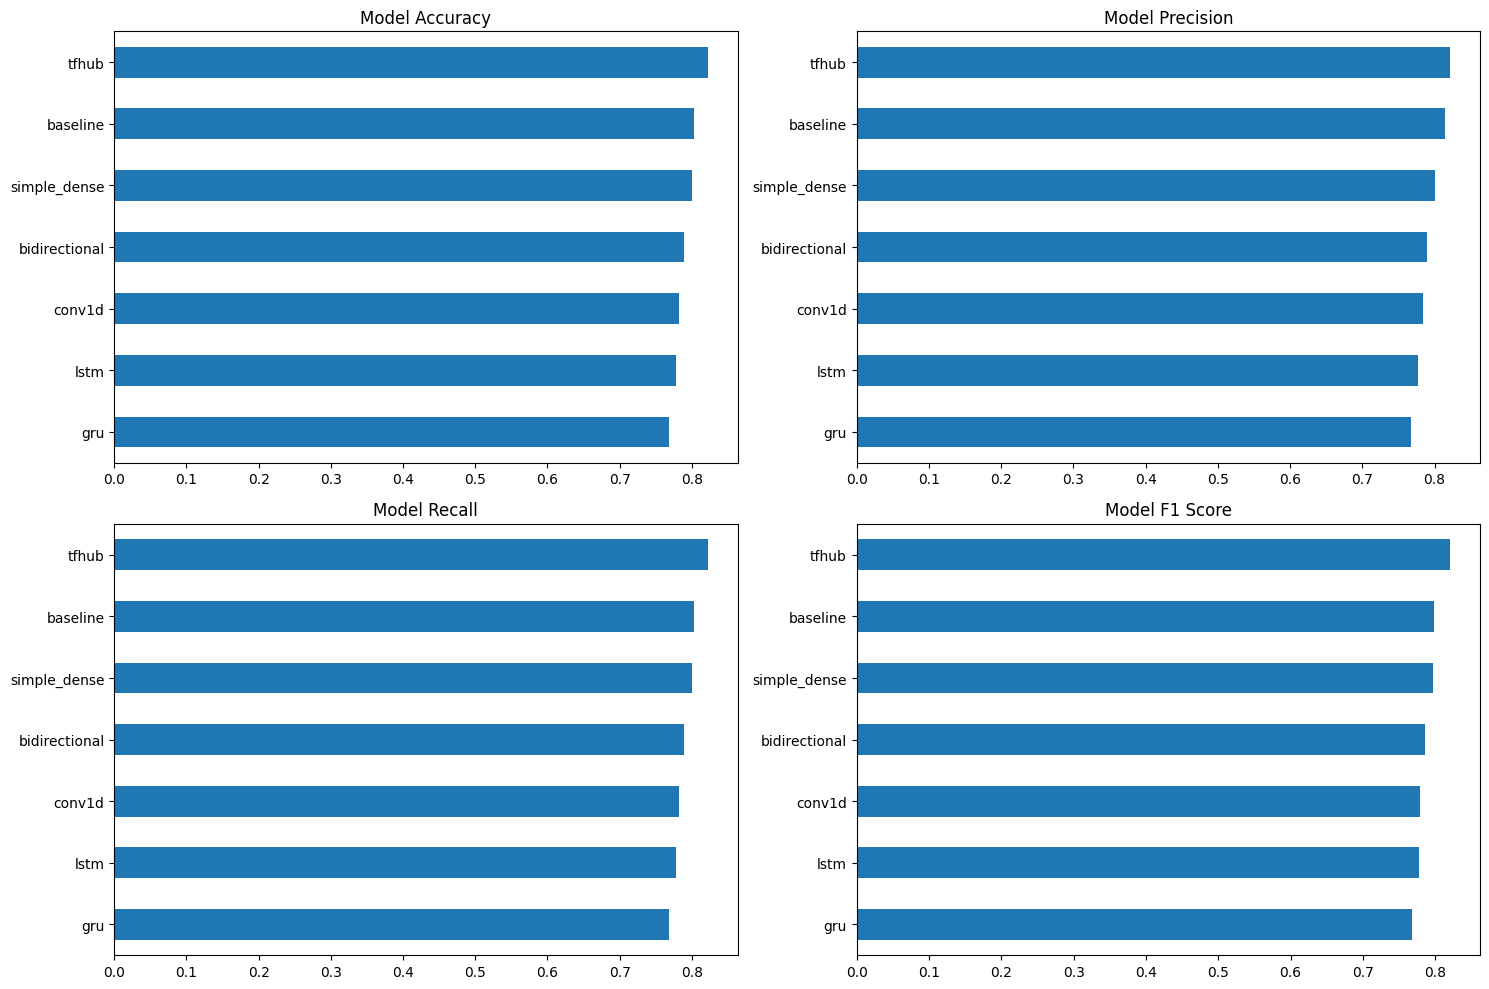

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(15,10))

# Subplot 1: Accuracy
plt.subplot(221)
all_model_results['Accuracy'].sort_values().plot(kind='barh', title='Model Accuracy')

# Subplot 2: Precision
plt.subplot(222)
all_model_results['Precision'].sort_values().plot(kind='barh', title='Model Precision')

# Subplot 3: Recall
plt.subplot(223)
all_model_results['Recall'].sort_values().plot(kind='barh', title='Model Recall')

# Subplot 4: F1 Score
plt.subplot(224)
all_model_results['F1 Score'].sort_values().plot(kind='barh', title='Model F1 Score')

plt.tight_layout()
plt.show()

In [75]:
# Calculate prediction probabilities
y_pred_prob = model_07.predict_proba(X_test_embeddings)

# Create a DataFrame for easier manipulation
df = pd.DataFrame({
    'text': X_test,
    'true_label': y_test,
    'predicted_label': y_pred,
    'prob_0': y_pred_prob[:, 0],
    'prob_1': y_pred_prob[:, 1]
})

# Calculate the probability of the correct class for each prediction
df['correct_prob'] = np.where(df['true_label'] == df['predicted_label'], np.max(y_pred_prob, axis=1), np.min(y_pred_prob, axis=1))

# Sort by correct_prob to find the most correct and most wrong predictions
most_correct = df.sort_values(by='correct_prob', ascending=False)
most_wrong = df.sort_values(by='correct_prob')

In [76]:
# Display the most correct predictions
print("Most correct predictions:")
most_correct.head(20)

Most correct predictions:


,text,true_label,predicted_label,prob_0,prob_1,correct_prob
2263,Businesses are deluged with invoices. Make you...,0,0,0.992582,0.007418,0.992582
3353,Entire town of Roosevelt Wash. evacuated becau...,1,1,0.007994,0.992006,0.992006
408,Arson suspect linked to 30 fires caught in Nor...,1,1,0.008157,0.991843,0.991843
4864,If your friends really were your friends they'...,0,0,0.988565,0.011435,0.988565
2264,Businesses are|deluged with invoices. Make y u...,0,0,0.988463,0.011537,0.988463
2164,Malaysia Airlines Flight 370 that Disappeared ...,1,1,0.012386,0.987614,0.987614
1047,ÛÏParties and body bags go together like drin...,0,0,0.986957,0.013043,0.986957
1302,The 8-Minute Fat-Burning Routine ThatÛªs Also...,0,0,0.986783,0.013217,0.986783
4691,Latest: Landslide kills three near Venice afte...,1,1,0.013550,0.986450,0.986450
3362,#Breaking: Authorities have issued new mandato...,1,1,0.014106,0.985894,0.985894


In [77]:
# Display the most wrong predictions
print("\nMost wrong predictions:")
most_wrong.head(20)


Most wrong predictions:


,text,true_label,predicted_label,prob_0,prob_1,correct_prob
2260,Businesses are deluged with invoices. Make you...,1,0,0.985822,0.014178,0.014178
6221,I get to smoke my shit in peace,1,0,0.969009,0.030991,0.030991
7203,Even if u have your weapon and your badge we g...,1,0,0.967416,0.032584,0.032584
547,STAR WARS POWER OF THE JEDI COLLECTION 1 BATTL...,1,0,0.963789,0.036211,0.036211
1005,'I did another one I did another one. You stil...,1,0,0.959776,0.040224,0.040224
842,I call it a little bit of your blizzard?,1,0,0.959103,0.040897,0.040897
3954,@adorableappple No reported flooding po in the...,0,1,0.046160,0.953840,0.046160
4509,My back is so sunburned :(,1,0,0.942353,0.057647,0.057647
2481,Me watching Law &amp; Order (IB: @sauldale305)...,1,0,0.939042,0.060958,0.060958
1817,@brianroemmele UX fail of EMV - people want to...,1,0,0.937596,0.062404,0.062404


In [78]:
def display_predictions(df, n=20, most_correct=True):
    if most_correct:
        sorted_df = df.sort_values(by='correct_prob', ascending=False)
        title = "Most correct predictions"
    else:
        sorted_df = df.sort_values(by='correct_prob')
        title = "Most wrong predictions"

    print(title)
    print("=" * len(title))
    
    for i, row in sorted_df.head(n).iterrows():
        print("\nText:", row['text'])
        print("True Label:", row['true_label'])
        print("Predicted Label:", row['predicted_label'])
        print("Probability of Correct Class: {:.4f}".format(row['correct_prob']))

In [79]:
# Display the most correct predictions
display_predictions(df, n=20, most_correct=True)

Most correct predictions

Text: Businesses are deluged with invoices. Make yours stand ogt with colomr or shape and it's likely to rise to the top of the pay' pile.
True Label: 0
Predicted Label: 0
Probability of Correct Class: 0.9926

Text: Entire town of Roosevelt Wash. evacuated because of wildfire http://t.co/CmwEIojJ55
True Label: 1
Predicted Label: 1
Probability of Correct Class: 0.9920

Text: Arson suspect linked to 30 fires caught in Northern California http://t.co/wnuqQAtTTP (via @latimes)
True Label: 1
Predicted Label: 1
Probability of Correct Class: 0.9918

Text: If your friends really were your friends they'd support you regardless of your decisions.

Unless you become a mass-murderer or something
True Label: 0
Predicted Label: 0
Probability of Correct Class: 0.9886

Text: Businesses are|deluged with invoices. Make y urs stand out with colour or shape and it's likely to rise to the top of the pay' pile.
True Label: 0
Predicted Label: 0
Probability of Correct Class: 0.9885



In [80]:
# Display the most wrong predictions
display_predictions(df, n=20, most_correct=False)

Most wrong predictions

Text: Businesses are deluged with invoices. Make yours stand out with colour or shape and it's likely to rise to the top of t e pay' pileq
True Label: 1
Predicted Label: 0
Probability of Correct Class: 0.0142

Text: I get to smoke my shit in peace
True Label: 1
Predicted Label: 0
Probability of Correct Class: 0.0310

Text: Even if u have your weapon and your badge we gonna put them choppas on your ass????
True Label: 1
Predicted Label: 0
Probability of Correct Class: 0.0326

Text: STAR WARS POWER OF THE JEDI COLLECTION 1 BATTLE DROID HASBRO - Full read by eBay http://t.co/xFguklrlTf http://t.co/FeGu8hWMc4
True Label: 1
Predicted Label: 0
Probability of Correct Class: 0.0362

Text: 'I did another one I did another one. You still ain't done shit about the other one.' Nigga body bagging Meek.
True Label: 1
Predicted Label: 0
Probability of Correct Class: 0.0402

Text: I call it a little bit of your blizzard?
True Label: 1
Predicted Label: 0
Probability of Correct C

In [93]:
import time

# Baseline model
start_time = time.time()
model_01.fit(X_train, y_train)
y_pred = model_01.predict(X_test)
end_time = time.time()
baseline_model_time = end_time - start_time
baseline_model_results_01 = calculate_scores(y_test, y_pred)

# Model 7
start_time = time.time()
model_07.fit(X_train_embeddings, y_train)
y_pred = model_07.predict(X_test_embeddings)
end_time = time.time()
tfhub_model_time = end_time - start_time
tfhub_model_results_07 = calculate_scores(y_test, y_pred)

# Print the time taken by each model
print("Baseline model time:", baseline_model_time)
print("Model 7 time:", tfhub_model_time)

Accuracy: 0.7997373604727511
Precision: 0.8102693639254774
Recall: 0.7997373604727511
F1 Score: 0.7932459520374361
Accuracy: 0.8220617202889035
Precision: 0.8217304568967476
Recall: 0.8220617202889035
F1 Score: 0.8209452400803882
Baseline model time: 0.2298891544342041
Model 7 time: 0.2496950626373291


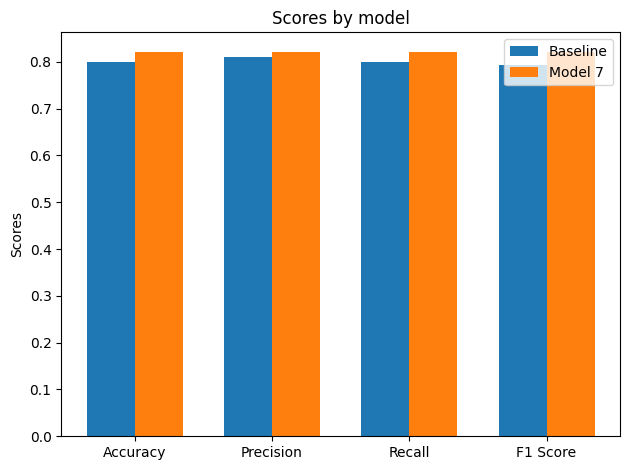

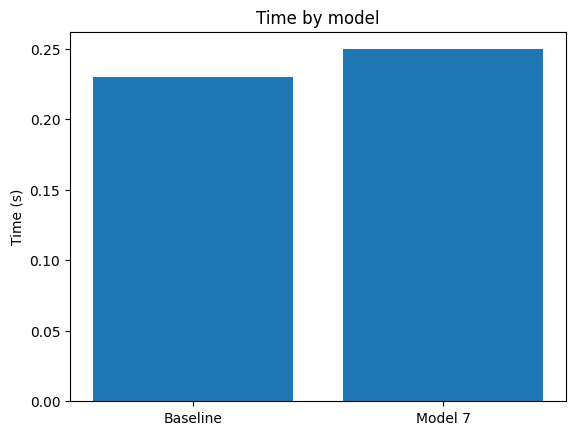

In [94]:
# Scores
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
baseline_scores = list(baseline_model_results_01.values())
tfhub_scores = list(tfhub_model_results_07.values())

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, baseline_scores, width, label='Baseline')
rects2 = ax.bar(x + width/2, tfhub_scores, width, label='Model 7')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# Time
labels = ['Baseline', 'Model 7']
times = [baseline_model_time, tfhub_model_time]

fig, ax = plt.subplots()
rects = ax.bar(labels, times)

ax.set_ylabel('Time (s)')
ax.set_title('Time by model')

plt.show()

Above is a Speed-Score comparison between model_07 and baseline

Speed-Score Tradeoff is the balance between the computational efficiency (speed) and the predictive performance (score) of a machine learning model, especially in the context of deep learning. 

On one hand, we have the speed of the model, which is about how fast the model can make predictions. This is particularly important in real-time applications where predictions need to be made quickly. On the other hand, we have the score of the model, which is about the accuracy of the predictions. The higher the score, the better the model is at making correct predictions.

However, there is often a tradeoff between these two aspects. More complex models, such as deep neural networks, often have higher scores because they can capture more complex patterns in the data. But these models are also more computationally intensive, which means they are slower to train and to make predictions.

On the contrary, simpler models, such as linear regression or decision trees, are faster to train and make predictions, but they may not capture the complexity of the data as well, resulting in lower scores.

Therefore, when designing a machine learning model, it's important to consider both the speed and the score. The ideal model is one that achieves a good balance between the two, providing accurate predictions quickly. This tradeoff can be managed by techniques like model pruning, quantization, and using efficient hardware accelerators.